In [25]:
import os
import sys
import json
import subprocess
import shutil
import random

if 'SUMO_HOME' in os.environ:
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
import sumolib
import importlib
from pprint import pprint
import pandas as pd
import xml.etree.ElementTree as ET
from xml.dom import minidom

# Add the "scripts" directory to sys.path
current_dir = os.path.dirname(os.path.abspath("__file__"))
scripts_dir = os.path.abspath(os.path.join(current_dir, 'scripts'))
sys.path.append(scripts_dir)
import vehParameters
import osmAPI as osm
import LLAMAconnect

FOLDER_NAME = "unicamp"

In [3]:
def update_xml_parameter(file_path, parameter, new_value, operation="modify"):
    """
    Updates or appends the value of a specified parameter in the given XML configuration file.

    Args:
        file_path (str): Path to the XML configuration file.
        parameter (str): The parameter to be updated (e.g., 'route-files').
        new_value (str): The new value to set or append to the parameter.
        operation (str): The operation to perform ('modify' or 'append'). Default is 'modify'.

    Returns:
        bool: True if the update was successful, False otherwise.
    """
    try:
        # Parse the XML file
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Search for the parameter within the XML
        for elem in root.iter():
            if elem.tag == parameter:
                current_value = elem.get('value', '')

                if operation == "modify":
                    # Set the new value, replacing the old one
                    elem.set('value', new_value)
                    print(f"Modified {parameter} to {new_value}")
                elif operation == "append":
                    # Append the new value if it already exists
                    if current_value:
                        new_value = f"{current_value}, {new_value}"
                    else:
                        new_value = f"{new_value}"
                    elem.set('value', new_value)
                    print(f"Appended new value: {new_value}")
                else:
                    print(f"Invalid operation: {operation}")
                    return False

                # Write the updated XML to the file
                tree.write(file_path, encoding="UTF-8", xml_declaration=True)
                return True

        print(f"Parameter {parameter} not found in the XML.")
        return False

    except Exception as e:
        print(f"An error occurred: {e}")
        return False


In [4]:
def add_xml_child(file_path, parent_tag, child_tag, child_value):
    """
    Adds a new child parameter inside a specified parent tag in the XML configuration file.
    If the parent tag does not exist, it creates a new parent tag (<parameter>) with the child.
    It also checks if the child element already exists to prevent duplicates.

    Args:
        file_path (str): Path to the XML configuration file.
        parent_tag (str): The parent tag under which to add the child (e.g., 'input').
        child_tag (str): The child tag to add (e.g., 'additional-files').
        child_value (str): The value to set for the new child tag.

    Returns:
        bool: True if the addition was successful, False otherwise.
    """
    try:
        # Parse the XML file
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Find the parent element by tag
        parent_elem = root.find(parent_tag)
        if parent_elem is None:
            print(f"Parent tag '{parent_tag}' not found. Creating new parent tag.")
            parent_elem = ET.Element(parent_tag)
            root.append(parent_elem)
            print(f"Created new parent tag <{parent_tag}>.")

        # Check if the child element already exists inside the parent element
        existing_child = parent_elem.find(child_tag)
        if existing_child is not None: 
            
            if existing_child.get('value') == child_value:
                print(f"Child <{child_tag}> with value '{child_value}' already exists. Skipping addition.")
                return False
            else:
                print(f"Child <{child_tag}> already exists. Updating value to '{child_value}'.")
                existing_child.set('value', child_value)
                tree.write(file_path, encoding="UTF-8", xml_declaration=True, method="xml")
                print("XML file updated successfully.")
                return True

        # Create the new child element and set its value
        new_child = ET.Element(child_tag)
        new_child.set('value', child_value)
        print(f"Created <{child_tag}> with value '{child_value}'.")

        # Add the new child to the parent element
        parent_elem.append(new_child)
        print(f"Added <{child_tag}> to <{parent_tag}>.")

        # Write the updated XML to the file
        tree.write(file_path, encoding="UTF-8", xml_declaration=True, method="xml")
        print("XML file updated successfully.")
        return True

    except ET.ParseError as e:
        print(f"XML Parsing error: {e}")
        return False
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

In [5]:
NET_PATH = f'{FOLDER_NAME}/osm.net.xml'
ADDITONALS_PATH = f'{FOLDER_NAME}/park.add.xml'
SUMOCFG_PATH = f'{FOLDER_NAME}/osm.sumocfg'
PA_REROUTER_PATH = f'{FOLDER_NAME}/pa_rerouter.xml'

# Setting up additional files
add_xml_child(SUMOCFG_PATH, 'input', 'additional-files', 'park.add.xml, pa_rerouter.xml')

# Setting up time to teleport as -1 (never teleport)
add_xml_child(SUMOCFG_PATH, 'processing', 'time-to-teleport', '-1')

# Adding lateral resolution to use SubLane model
add_xml_child(SUMOCFG_PATH, 'parameters', 'lateral-resolution', '0.8')

net = sumolib.net.readNet(NET_PATH)
parkingAreas = list(sumolib.output.parse(ADDITONALS_PATH, "parkingArea"))

Child <additional-files> with value 'park.add.xml, pa_rerouter.xml' already exists. Skipping addition.
Child <time-to-teleport> with value '-1' already exists. Skipping addition.
Child <lateral-resolution> with value '0.8' already exists. Skipping addition.


In [6]:
def flush_print():
    sys.stdout.write("\r")  # Move the cursor to the beginning of the line
    sys.stdout.write(" " * 50)  # Overwrite with spaces to clear the line
    sys.stdout.write("\r")  # Move back to the beginning again

In [8]:
def has_parking_spot(lanes, parkingAreas):
    # Example of parkingArea:
    # <parkingArea id="pa-1046248579#0" lane="-1046248579#0_0" roadsideCapacity="94" length="5.00"/>
    # Returns parkingArea id if there is a parking spot in the lane
    lane_ids = [lane.getID() for lane in lanes]
    for park in parkingAreas:
        if park.lane in lane_ids:
            return park.id
    return False

In [9]:
def getClosestEdges(lat, lon, radius, maxEdges=10):
    # Gets the 10 closest edges to the given lat, lon
    x, y = net.convertLonLat2XY(lon, lat)
    edges = net.getNeighboringEdges(x, y, radius)
    closestEdges = []
    if (len(edges) > 0):
        distanceAndEdges = sorted([(dist, edge) for edge, dist in edges], key=lambda x:x[0])

        ## Checking if the edge found can be used by passenger car
        for dist, edge in distanceAndEdges:
            if edge.allows('passenger'):
                closestEdges.append(edge)

    if len(edges) == 0:
        print(f'No edges found for {lat}, {lon}. Perhaps location is not inside the network or there are no viable roads inside the radius.')
        return None
    
    return closestEdges

In [10]:
def getParkingSpot(lat, lon, radius, parkingAreas):
    # Get the parking spot closest to the given lat, lon
    # Used to set stops for the vehicles

    edges = getClosestEdges(lat, lon, radius)
    # Look for parking spots
    for i in range(len(edges)):
        parking_spot = has_parking_spot(edges[i].getLanes(), parkingAreas)
        if parking_spot:
            return parking_spot
    print(f"No parking spot found close to {lat}, {lon}. Perhaps decrease the radius?")
    return None

In [11]:
def getPath(location_time_list, parkingAreas, steps_per_stop = 10):
    # All that is needed to create the trip are the stops (parking areas) and the start and end edges.
    # The duarouter is responsible for finding the path between the edges going through the stops.
    # Here, we get the edges and stops that are going to be sent to LLAMA to create the trip.

    # 'coordinates' is a list of tuples with the latitude and longitude of the points of interest, for example IC, FEEC, IC means that
    # the vehicle will start from IC, stop at a parking lot close to FEEC, and then back to IC.
    # The first and last coordinates should be edges and the others should be parking spots.
    # `steps_per_stop` is the number of simulation steps that the vehicle will stay at each stop.

    # Departure for 7 is 0, 8 is 100, 9 is 200 and so on
    stop_durations = []
    departures = list(location_time_list.keys())
    stop_durations.append(-1) # Indicates this is an edge and not a parking spot

    path = []
    locations = list(location_time_list.values())
    home = getClosestEdges(*locations[0], radius)[0].getID()
    path.append(home)
    
    for i in range(1, len(locations)-1):
        stop_durations.append(steps_per_stop * (departures[i] - departures[i - 1]))
        ps = getParkingSpot(*locations[i], radius, parkingAreas)
        if ps is not None:
            path.append(ps)
        else:
            print(f"Could not find parking spot for {locations[i]}")
            raise Exception(f"Could not find parking spot for {locations[i]}")

    path.append(home)
    stop_durations.append(-1)
    
    return path, stop_durations

In [12]:
def pathToXML(path, vehicleID, veh_type, departure_time, stop_durations):
    # Converts the path to the XML format that LLAMA understands
    xml = f'<trip id="{vehicleID}" type="{veh_type}" depart="{departure_time}" from="{path[0]}" to="{path[-1]}">\n'
    for i in range(1, len(path)-1):
        xml += f'\t<stop parkingArea="{path[i]}" duration="{stop_durations[i]}"/>\n'
    xml += '</trip>'
    return xml

Getting the routine for the students described

In [130]:
# It is important not to use short names of institutes, like IB for institute of biology, because the LLM will not be able to assign the students to the correct institute.
places ={
    'leisure': ["bar", "shopping_mall", "library", "park", "garden"],
    'eating': ["restaurant", "cafe"],
    'shopping': ["clothes", "mall", "supermarket", "department_store", "fuel"],
    'sports': ["fitness_centre"],
    'institute': ["Instituto de Computação", "Instituto de Química", "Instituto de Biologia"],
    'university': ["University of Campinas"],
}

student_info = "O estudante é um estudante de biologia que passa muito tempo na biblioteca."
importlib.reload(LLAMAconnect)
number_of_trips = 4
responses = LLAMAconnect.generate_response_trips(student_info, places, number_of_trips) # number of trips defaults to 5
for i in range(len(responses)):
    pprint(json.loads(responses[i]))
    print()

100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

{'10': {'activity': 'study', 'location': 'Instituto de Biologia'},
 '11': {'activity': 'leisure', 'location': 'library'},
 '12': {'activity': 'lunch', 'location': 'cafe'},
 '13': {'activity': 'study', 'location': 'Instituto de Biologia'},
 '14': {'activity': 'leisure', 'location': 'library'},
 '15': {'activity': 'practicing sports', 'location': 'fitness_centre'},
 '16': {'activity': 'leisure', 'location': 'library'},
 '17': {'activity': 'leisure', 'location': 'restaurant'},
 '18': {'activity': 'dinner', 'location': 'cafe'},
 '19': {'activity': 'leisure', 'location': 'library'},
 '20': {'activity': 'study', 'location': 'Instituto de Biologia'},
 '21': {'activity': 'relax', 'location': 'home'},
 '22': {'activity': 'relax', 'location': 'home'},
 '23': {'activity': 'sleep', 'location': 'home'},
 '7': {'activity': 'wake up', 'location': 'home'},
 '8': {'activity': 'study', 'location': 'Instituto de Biologia'},
 '9': {'activity': 'leisure', 'location': 'library'}}

{'10': {'activity': 'study

Generating different houses for students based on a random number generator in the where students might live

In [119]:
def getHome():
    # Should be a random value considering where students live
    return (-22.820634394979397, -47.07409276270959)

In [120]:
def getCoords(trip, sulfixo, institutes, start_radius, step_radius, limit_radius, n_options = 3):
    # Returns a dictionary with the latitude and longitude of the locations of interest
    # The suffix is the name of the state, city and neighborhood that will be added to the end of each location to improve the search
    # 'start_radius' is the initial radius of the search, 'step_radius' is the amount that will be added to the radius if the location is not found and 'limit_radius' is the maximum radius that will be used. After that, the student will choose not to leave the place he is at.
    # 'n_options' is the number of options of places we ideally want to find to choose from. This only applies while the limit_radius is not exceeded
    coords = {}
    place = {}
    importlib.reload(osm)
    for i in range(len(trip)):
        local = trip[f'{i + 7}']['location']
        local_comp = local + ", " + sulfixo

        if local in coords.keys():
            continue
        
        if local == 'home':
            coords['home'] = getHome()
            continue
        elif local in institutes:
                result = osm.geocode_address(local_comp)
                lat, lon = result[0]['latitude'], result[0]['longitude']
                print(f"\033[1mFound {local} at {lat}, {lon}.\033[0m")
        else:
            found = True
            print(f"Looking for {local}...", end='', flush=True)

            # Stoting the previous location to use as a reference for the next search
            previous = coords[trip[f'{i + 6}']['location']]
            result = osm.find_nearby_building(previous[0], previous[1], local, radius=start_radius)
            expanded = start_radius

            # If the location is not found or there are less optios than expected, expand the search radius
            while result is False or len(result) < n_options:
                expanded += step_radius
                if expanded > limit_radius:
                    found = False
                    break
                
                result = osm.find_nearby_building(previous[0], previous[1], local, radius=expanded)

            if found == False:
                result = [{'latitude': previous[0], 'longitude': previous[1]}]
                place[f'{local}'] = trip[f'{i + 6}']['location']
                flush_print()
                print(f"Could not find {local} in a radius of {limit_radius} meters. The student will not leave the place he is currently at.")
            else:
                place[f'{local}'] = result[0]['name']
                random.shuffle(result) # Randomize the results to avoid always getting the absolute closest building
                lat, lon = result[0]['latitude'], result[0]['longitude']
                flush_print()
                print(f"Found {len(result)} options for {local}: {[x['name'] for x in result]}")
                print(f"\033[1m{local} picked: {result[0]['name']} at {lat}, {lon}.\033[0m")

        
        coords[f'{local}'] = (lat, lon)
        
    return coords, place

In [121]:
def coordsToTrip(trip, coords):
    location_time = {}
    home = coords['home'] # Gets a random home location for each student
    last = home
    location_time[7] = last
    
    for j in range(1, len(trip)):
        local_coords = coords[trip[f'{j + 7}']['location']]
        if local_coords != last:
            location_time[j + 7] = local_coords
            last = local_coords

    return location_time

Getting the latitude and longitude for each of the locations

In [122]:
sufixo = "Barão Geraldo, Campinas, SP, Brazil"
trips = {}
location_time_list = []
radius = 200
for i in range(len(responses)):
    json_response = json.loads(responses[i])
    trips[i] = json_response
    print(f"Getting coords for trip {i + 1}:")
    coords, names = getCoords(trips[i], sufixo, places['institute'], start_radius=500, step_radius=200, limit_radius=1500)
    location_time_list.append(coordsToTrip(trips[i], coords))
    print("")
print("All trips have been successfully generated.")


Getting coords for trip 1:
Found Instituto de Biologia at -22.81998175, -47.07004201564925.
Found 6 options for library: ['Biblioteca da Física', 'Biblioteca do Instituto de Biologia', 'Biblioteca Octávio Ianni', 'Biblioteca do Instituto de Química', 'Biblioteca Central Cesar Lattes', 'Biblioteca de Obras Raras']
library picked: Biblioteca da Física at -22.8172824, -47.0668432.
Found 5 options for cafe: ['Cantina do Gatti', 'Cantina do DCE', 'Cantina do Instituto de Economia', 'Cantina da Biologia', 'Cantina do IB']
cafe picked: Cantina do Gatti at -22.8151128, -47.0641539.
Found 4 options for fitness_centre: ['Jardim Aéreo', 'O Funcional', 'Academia Cinética', 'Academia Golden']
fitness_centre picked: Jardim Aéreo at -22.8240748, -47.0783786.
Found 4 options for restaurant: ['Cantina da Biologia', 'Restaurante Universitário', 'Bardana', 'Aulus']
restaurant picked: Cantina da Biologia at -22.8186661, -47.0695796.

Getting coords for trip 2:
Found Instituto de Biologia at -22.81998175, 

# Random Trips and Driving Styles

In [123]:
randomtrips_path = "/usr/share/sumo/tools/randomTrips.py"
def randomtrips_getArgs(net_path, additional_path, v_class, n_trips):
    args = [
        "-n", net_path,
        "-o", f"{FOLDER_NAME}/randtrips.trips.xml",
        "-r", f"{FOLDER_NAME}/randtrips.rou.xml",
        "--additional", additional_path,
        "--vclass", v_class,
        "--vehicle-class", v_class,
        "-e", str(n_trips),
        "--validate"
    ]
    return args

In [124]:
def getRandomTrips(net_path, add_path, vclass, n_trips):
    # Run the randomTrips.py to create the trips
    subprocess.run(['python3', randomtrips_path] + randomtrips_getArgs(net_path, add_path, vclass, n_trips), check=True)

In [125]:
def parseTripXML(param_dict, location_time_list, parkingAreas, departure_times, styles, veh_types_per_student, n_vtypes, steps_per_stop = 10, rand_trips=None, out_file_name='finaltrips.rou.xml'):
    # Creates the XML for the trips
    # 'departure_times' is a list with the departure times for each trip
    # 'styles' is a list with the styles of the vehicles. The current supported styles are "agg" for aggressive and "norm" for normal
    # 'veh_types_per_student' is a list with the vehicle types for each student
    # 'n_vtypes' is the number of vTypes created for each style
    # 'rand_trips' is a file containing the random trips
    
    importlib.reload(vehParameters)

    xml = '<routes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/routes_file.xsd">\n'

    xml += '\n<!-- BEGIN - LLM Generated trips -->\n'

    xml += '\n<!-- Vehicles -->\n'
    vehdists = vehParameters.generateVehicleTypesLLM(param_dict, styles, n_vtypes)
    xml += vehParameters.parseVehiclesXML(vehdists, styles, FOLDER_NAME)

    xml += '\n'
    xml += '<!-- Trips -->\n'
    for i in range(len(location_time_list)):
        path, stop_durations = getPath(location_time_list[i], parkingAreas, steps_per_stop=steps_per_stop)
        xml += pathToXML(path, f'veh{i + 1}', veh_types_per_student[i], departure_times[i], stop_durations) + '\n'

    xml += '\n\n <!-- END - LLM Generated trips -->\n\n'

    xml += '<!-- BEGIN - Random Trips -->\n\n'

    if rand_trips:
        start_read = False
        with open(rand_trips, 'r') as f:
            for line in f:
                test = line.strip()
                if test.startswith('<vType'):
                    start_read = True
                if start_read:
                    if line.startswith('</routes>'):
                        break
                    xml += line

    xml += '\n</routes>'
    
    with open(f'{FOLDER_NAME}/{out_file_name}', 'w') as f:
        f.write(xml)
    
    return xml

In [126]:
def csv_str(data):
    # Returns a string with the parameters and their descriptions to be used with the LLM
    s = ''
    for i in range(len(data)):
        s += f"Parameter: {data['Parameter'][i]}; Range: {data['Range'][i]}; Description: {data['Description'][i]}."
    return s

In [127]:
departure_times = []
for i in range(len(location_time_list)):
    departure_times.append((list(location_time_list[i].keys())[0] - 7) * 10)

In [128]:
styles = ["aggressive", "normal", "cautious", "super_aggressive"] # Description of the styles of the vehicles that are going to be generated
data = pd.read_csv('DBP.csv')
params = csv_str(data) # Turns the csv file into a string that can be passed to the LLM
importlib.reload(LLAMAconnect)
veh_parameters = LLAMAconnect.generate_range_parameters(params, styles) # Generates the parameters for the vehicles
param_dict = json.loads(veh_parameters)

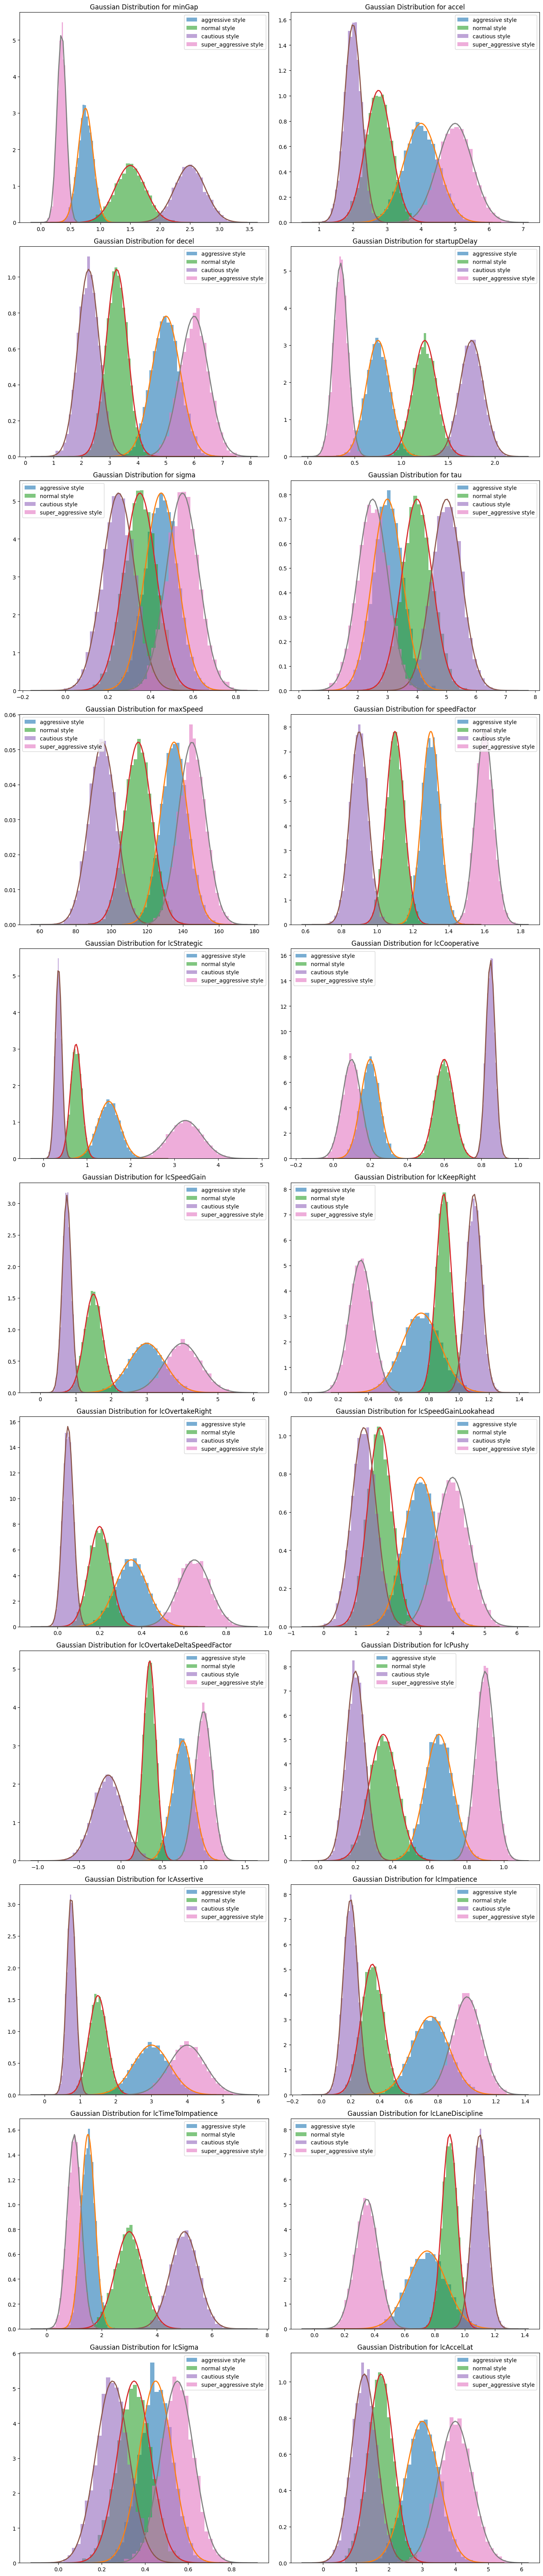

In [129]:
importlib.reload(vehParameters)
vehParameters.showGaussianLLM(param_dict, [data['Parameter'][i] for i in range(len(data['Parameter']))], styles) # Shows distribution of the parameters for verification

In [131]:
n_vtypes = 5 
veh_style_per_student = []
for i in range(len(location_time_list)):
    veh_style_per_student.append(styles[i % len(styles)]) # Balacing the styles for the vehicles


# IMPORTANT: If the desire is to generate alternative routes for the random trips, rand_trips must be set to randtrips.trips.xml, otherwise, the random_trips will be merged with the alternative routes for the LLM generated trips.
# If rand_trips is set to None, the PATHGEN.rou.alt.xml file should be used in osm.sumocfg. Otherwise, the merged.rou.alt.xml file should be used.
rand_trips = None
final_trips_file_name = "finaltrips.rou.xml"

getRandomTrips(NET_PATH, ADDITONALS_PATH, "passenger", 10) # Generating random trips to randomtrips.rou.xml
parseTripXML(param_dict, location_time_list, parkingAreas, departure_times, styles, veh_style_per_student, n_vtypes, steps_per_stop=10, rand_trips=rand_trips, out_file_name=final_trips_file_name) # Parsing to PATHGEN.trips.xml

Success.
Success.


'<routes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/routes_file.xsd">\n\n<!-- BEGIN - LLM Generated trips -->\n\n<!-- Vehicles -->\n<vTypeDistribution id="aggressive">\n\t<vType id="v_aggressive0" minGap="0.53" accel="4.05" decel="5.48" startupDelay="0.94" sigma="0.5" tau="2.84" maxSpeed="131.78" speedFactor="1.23" lcStrategic="1.68" lcCooperative="0.24" lcSpeedGain="3.78" lcKeepRight="0.85" lcOvertakeRight="0.29" lcSpeedGainLookahead="2.84" lcOvertakeDeltaSpeedFactor="0.53" lcPushy="0.65" lcAssertive="2.94" lcImpatience="0.67" lcTimeToImpatience="1.7" lcLaneDiscipline="0.55" lcSigma="0.43" lcAccelLat="3.67" probability="0.132827118460643">\n\t\t<param key="device.rerouting.probability" value="1.0"/>\n\t\t<param key="device.rerouting.adaptation-steps" value="18"/>\n\t\t<param key="device.rerouting.adaptation-interval" value="10"/>\n\t</vType>\n\t<vType id="v_aggressive1" minGap="0.88" accel="3.66" decel="4.92" startupDela

Getting alternative routes for every route found

In [132]:
## Arguments to get alternative routes
duaiterate_path = "/usr/share/sumo/tools/assign/duaIterate.py"
def duaiterate_getArgs(net_path, trips_path, additional_path, iterations):
    args = [
        "-n", net_path,
        "-t", trips_path,
        "--additional", additional_path,
        "duarouter--additional-files", additional_path,
        "-l", str(iterations),
    ]
    return args

In [133]:
def getAltRoutes(net_path, trips_path, additional_path, iterations):
    # Run the duarouter to find alternative routes
    # Currently this only works for less than 10 iterations because of file naming
    try:
        subprocess.run(['python3', duaiterate_path] + duaiterate_getArgs(net_path, f'{FOLDER_NAME}/{trips_path}', additional_path, iterations), check=True)
        file_name = trips_path.split('.')[0]

        shutil.move(f'00{iterations-1}/{file_name}_00{iterations-1}.rou.alt.xml', f'{FOLDER_NAME}/{file_name}.rou.alt.xml')
        for i in range(iterations):
            if os.path.exists(f'00{i}'):
                shutil.rmtree(f'00{i}')

        shutil.move('dua.log', f'{FOLDER_NAME}/dua.log')
        shutil.move('stdout.log', f'{FOLDER_NAME}/stdout.log')
        os.remove('edgedata.add.xml')
                
    except subprocess.CalledProcessError as e:
        print(f"{e}")

In [134]:
# This creates the {final_trips_file_name}.rou.alt.xml file
getAltRoutes(NET_PATH, final_trips_file_name, ADDITONALS_PATH, 1)

> Executing step 0
>> Running router on unicamp/finaltrips.rou.xml
>>> Begin time: 2024-12-12 15:56:07.591606
>>> End time: 2024-12-12 15:56:08.408363
>>> Duration: 0:00:00.816757
<<
>> Running simulation
>>> Begin time: 2024-12-12 15:56:08.408469
>>> End time: 2024-12-12 15:56:09.887703
>>> Duration: 0:00:01.479234
<<
< Step 0 ended (duration: 0:00:02.296353)
------------------

dua-iterate ended (duration: 0:00:02.307929)


If there is no need to generate alternative router for the random trips, the following XML parser must be used to add them:

In [135]:
def merge_routes(alternative_routes, random_routes, output_file_name = 'merged.rou.alt.xml'):
    # Merges two route files into one
    
    xml = '<routes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/routes_file.xsd">\n'
    xml += '\n<!-- BEGIN - LLM Generated trips -->\n'

    with open(alternative_routes, 'r') as f:
        start_read = False
        for line in f:
            test = line.strip()
            if test.startswith('<vType'):
                start_read = True
            if start_read:
                if line.startswith('</routes>'):
                    break
                xml += line

    xml += '\n\n <!-- END - LLM Generated trips -->\n\n'
    xml += '<!-- BEGIN - Random Trips -->\n\n'

    with open(random_routes, 'r') as f:
        start_read = False
        for line in f:
            test = line.strip()
            if test.startswith('<vType'):
                start_read = True
            if start_read:
                xml += line

    with open(f'{FOLDER_NAME}/{output_file_name}', 'w') as f:
        f.write(xml)
    
    return xml    

In [136]:
# If alternative routes for random trips were ignored, the 'merged.rou.alt.xml' file will be created and should be used in osm.sumocfg
output_file_name = 'merged.rou.alt.xml'
if rand_trips == None:
    if os.path.exists(f'{FOLDER_NAME}/{output_file_name}'):
        os.remove(f'{FOLDER_NAME}/{output_file_name}')
    
    # If there are alternative routes, merge them
    if os.path.exists(f'{FOLDER_NAME}/finaltrips.rou.alt.xml'):
        merge_routes(f'{FOLDER_NAME}/finaltrips.rou.alt.xml', f'{FOLDER_NAME}/randtrips.rou.xml', output_file_name)

    # If alternative routes were found not generated, we are going to use the original ones
    else:
        merge_routes(f'{FOLDER_NAME}/finaltrips.rou.xml', f'{FOLDER_NAME}/randtrips.rou.xml', output_file_name)

# Changing sumocfg to use the new route file
update_xml_parameter(SUMOCFG_PATH, 'route-files', output_file_name, operation="modify")

Modified route-files to merged.rou.alt.xml


True